---
format:
  html:
    other-links:
      - text: This notebook
        href: L6-7 Solving nonlinear equations in 1d II.ipynb
---

# Solving nonlinear equations in 1d II

<div style='background-color: #ffe0b2; padding: 10px; border-left: 5px solid #ff9800;'><strong>Note.</strong>  This chapter will be mainly based on Chapter 1 of An Introduction to Numerical Analysis by Suli, Mayers. These notes are mainly a record of what we discussed and are not a substitute for attending the lectures and reading books! If anything is unclear/wrong, let me know and I will update the notes.
 </div> 

In [15]:
# | include: false

using Plots
using LaTeXStrings
using Polynomials
using PrettyTables

function simple_iteration( g, x1; N=100, tol=1e-10 )
    x = [ x1 ]
    for n in 2:N
        push!( x, g(x[n-1]) )
        if (abs(g(x[end]) - x[end]) < tol)
            break
        elseif (x[end] == Inf)
            @warn "simple iteration diverges to Inf";
            break
        elseif (x[end] == -Inf)
            @warn "simple iteration diverges to -Inf";
            break
        end 
    end
    return x
end

function relaxation( f, λ, x1; N=100, tol=1e-10)
    x = [x1]
    r = 0.;
    for n in 2:N
        push!( x, x[n-1] - λ*f(x[n-1]) )
        r = abs(f(x[end]));
        if (r < tol)
            return x
        end
    end
    @warn "max interations with |f| = $r";
    return x
end

function Newton( f, f_prime, x1; N=100, tol=1e-10)
    x = [x1]
    for n in 2:N
        push!( x, x[n-1] - f(x[n-1])/f_prime(x[n-1]) )
        r = abs(f(x[end]));
        if (r < tol)
            return x
        end
    end
    @warn "max interations |f| = $r";
    return x
end

function orderOfConvergence( x, ξ; α=0)
    err = @. abs(x - ξ)
    logerr = @. log10( err )
    ratios = [NaN; [logerr[i+1] / logerr[i] for i in 1:length(logerr)-1]]
    if (α == 0) 
        α = ratios[end]
        αr = round(α, sigdigits=3)
    end
    mu = [NaN; [err[i+1] / err[i]^α for i in 1:length(err)-1]]
    pretty_table(
        [1:length(x) err logerr ratios mu];
        column_labels = ["iteration", "absolute error", "log error", "alpha", "mu (α = $α)" ] 
    )
end

function μ( x, ξ; α=1 )
    return @. abs( x[2:end] - ξ ) / ( abs(x[1:end-1] - ξ )^α );
end 

μ (generic function with 1 method)

## Results from Calculus

<div class='alert alert-block alert-info'><b>⚠ Intermediate Value Theorem</b> 

Suppose that $f : [a,b] \to \mathbb  R$ is continuous. Then, $f$ is bounded on $[a,b]$ and for all $y \in [\min_{[a,b]} f, \max_{[a,b]} f ]$ there exists $x\in[a,b]$ such that $f(x) = y$. 

</div> 

<div class='alert alert-block alert-info'><b>⚠ Mean Value Theorem</b> 

Suppose that $f \colon [a,b] \to \mathbb R$ is continuous on $[a,b]$ and differentiable on $(a,b)$. Then, there exists $c\in[a,b]$ for which 

\begin{align*}
    f(b) - f(a) = f'(c) (b-a)
\end{align*}

</div> 

*Proof:* Consider $g(x) := f(x) - \frac{f(b)-f(a)}{b-a} x$, a function for which $g(a) = g(b)$. You can show that there exists $c\in [a,b]$ for which $g'(c) = 0$ (this is known as Rolle's theorem). This follows from the intermediate value theorem - either the max or min is achieved at $a$ and $b$ (and the function is constant), or there is an extreme point in $(a,b)$. In the latter case, you can show this point is stationary: i.e. $g'$ vanishes here. 

<b>Cauchy's Mean Value Theorem</b> (need this for the proof of Taylor remainder theorem)

Suppose that $f, g \colon [a,b] \to \mathbb R$ are continuous on $[a,b]$ and differentiable on $(a,b)$. Then, there exists $c\in[a,b]$ for which 

\begin{align*}
    \big( f(b) - f(a) \big) g'(c) = \big(g(b) - g(a) \big) f'(c)
\end{align*}

*Proof:* $h(x) = \big( g(b) - g(a) \big) f(x) - \big( f(b) - f(a) \big) g(x)$ is such that $h(a) = h(b)$ and so there exists $c \in [a,b]$ such that $h'(c) = 0$.

<div class='alert alert-block alert-info'><b>⚠ Taylor Remainder Theorem</b> 

Suppose that $f\colon [a,b] \to \mathbb R$ is a function with $n$ times continuously differentiable. Then, there exists $c\in[a,b]$ for which 

\begin{align*}
    f(x) = f(a) + f'(a) (x - a) + \dots + \frac{f^{(n-1)}(a)}{(n-1)!} (x - a)^{n-1} + \frac{f^{(n)}(c)}{n!} (x-a)^{n}
\end{align*}

</div>



*Proof:* Define $F(x) = f(x) - \sum_{k=0}^{n-1} \frac{f^{(k)}(a)}{k!} (x - a)^k$ and $G(x) = (x-a)^n$ and note that $F(a) = F'(a) = \cdots = F^{(n-1)}(a) = 0$ and $G(a) = \cdots = G^{(n-1)}(a) = 0$ and $G^{(n)}(x) = n!$. Applying Cauchy's Mean Value Theorem $n$ times, we can conclude there exists $c_1,\dots,c_n$ between $a$ and $x$ such that

\begin{align*}
    \frac{F(x)}{G(x)} &= \frac{F(x) - F(a)}{G(x) - G(a)}
    = \frac{F'(c_1)}{G'(c_1)} \nonumber\\ 
    &= \frac{F'(c_1) - F'(a)}{G'(c_1) - G'(a)}
    = \frac{F''(c_2)}{G''(c_2)} \nonumber\\ 
    &= \cdots = \frac{F^{(n)}(c_n)}{G^{(n)}(c_n)}
    %
    = \frac
        {f^{(n)}(c_n)}
        { n! }
\end{align*}


## Previously....

<div class='alert alert-block alert-info'><b>⚠ Change of Sign Theorem</b> 

Suppose that $f\colon [a,b] \to \mathbb R$ is a continuous function with $f(a) f(b) \leq 0$. Then, $f$ has a *root* (or *zero*) $\xi \in [a,b]$ (i.e. $f(\xi) = 0$). 

</div>

*Proof.* If $f(a) f(b) = 0$ then $a$ or $b$ is a root of $f$. Otherwise, $0 \in (\min_{[a,b]}f, \max_{[a,b]}f)$ and so the Intermediate Value Theorem applies.  

<div class='alert alert-block alert-info'><b>⚠ Brouwer's Fixed Point Theorem.</b> 

Suppose that $g \colon [a,b] \to [a,b]$ is continuous. Then, there exists a fixed point $\xi \in [a,b]$.

</div> 

*Proof.* We can apply the change of sign theorem to $f(x) := g(x) - x$.

<div style='background-color: #ddff99; padding: 10px; border-left: 5px solid #009933;'><strong>Definition. (Contraction)</strong> 

A function $g : [a,b] \to \mathbb R$ is a *contraction* if there exists $L \in (0,1)$ such that 

\begin{align}
    |g(x)-g(y)|\leq L|x-y|
\end{align}

for all $x,y \in [a,b]$,

 </div> 

By the Mean Value Theorem, if $|g'|\leq L < 1$ on $[a,b]$, then $g$ is a contraction on $[a,b]$. 

<div class='alert alert-block alert-info'><b>⚠ Contraction Mapping Theorem</b> (also called Banach's fixed point theorem)</b> 

Suppose $g:[a,b] \to[a,b]$ is a contraction. Then, there exists a unique fixed point $\xi = g(\xi) \in [a,b]$. Moreover, the iteration $x_{n+1} = g(x_n)$ converges at least linearly to $\xi$ for all $x_1 \in [a,b]$.

 </div> 

*Proof.* Existence of a fixed point $\xi = g(\xi)$ follows from Brouwer's fixed point theorem. If there exists $\zeta = g(\zeta) \in [a,b]$ then $|\xi - \zeta| = |g(\xi) - g(\zeta)| \leq L |\xi - \zeta|$. Since $L \in (0,1)$, we must have $\xi = \zeta$ and the fixed point is unique. 

Notice that $|x_{n+1} - \xi| = |g(x_n) - g(\xi)| \leq L |x_n - \xi|$ for all $n \geq 1$. Therefore, we have $|x_{n+1} - \xi| \leq L^n |x_1 - \xi|$ which goes to zero as $n\to\infty$ (as $|L|<1$). Finally, we note that by the Mean Value Theorem there exist $\eta_n$ between $x_n$ and $\xi$ such that

\begin{align}
    \frac
        {|x_{n+1} - \xi|}
        {|x_n - \xi|}
    %
    = \frac
        {|g(x_{n}) - g(\xi)|}
        {|x_n - \xi|}
    = |g'(\eta_n)|.
\end{align}

This quantity converges to $|g'(\xi)|$ as $n \to \infty$.


<div class='alert alert-block alert-info'><b>Theorem.</b> 

Suppose $g$ is continuously differentiable with fixed point $\xi$. Then, if $|g'(\xi)| >1$, then $\xi$ is an unstable fixed point of $g$.

 </div> 

*Proof.* Since $g'$ is continuous, there exists an interval $I$ containing $\xi$ such that $|g'| \geq L > 1$ on $I$. Consider the iteration $x_{n+1} = g(x_n)$. By the intermediate value theorem, if $x_1 \in I \setminus\{\xi\}$, there exists $\eta_1 \in I$ for which $|x_{2} - \xi| = |g(x_1) - g(\xi)| = |g'(\eta_1) (x_1 - \xi)| \geq L | x_1 - \xi |$. Similarly, if $x_{2}, \dots, x_{N} \in I$ then 

\begin{align}
    |x_{N+1} - \xi| = |g(x_{N}) - g(\xi)|
    %
    &\geq L|x_{N}-\xi| \geq \cdots \geq L^{N} |x_{1}-\xi|.
\end{align}

Since $L>1$ and $x_1 \not=\xi$, we have $x_{N+1} \not\in I$ for sufficiently large $N$. If the sequence returns to $I$: if there exists $m$ such that $x_m \in I$, then by the exact same argument as above $x_{m+M} \not\in I$ for sufficiently large $M$. As a result, $(x_n) \not\to \xi$.   

## Relaxation

* Define $x_{n+1} = x_{n} - \lambda f(x_{n})$ 

<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example (Kepler's Equation)</strong> 
</div> 

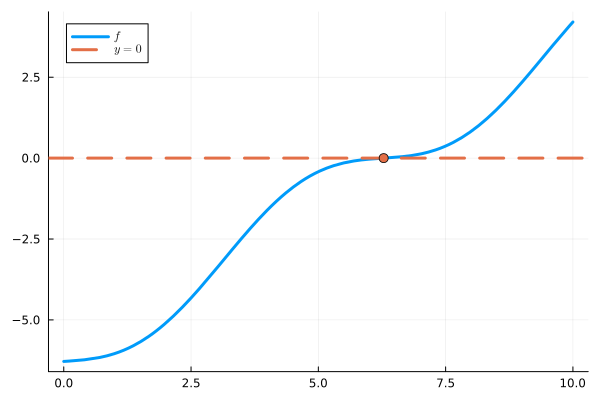

In [16]:
# Kepler's equation with t = τ = 1 
ϵ = 0.9;

f = ψ -> ψ - ϵ * sin(ψ) - 2π; # has a zero at 2π
f_prime = ψ -> 1 - ϵ * cos(ψ);
f_2prime = ψ -> ϵ * sin(ψ);

ξ = 2π;

plot( f, 0, 10, label=L"f", lw=3 )
hline!( [0] , linestyle=:dash, lw = 3, label=L"y=0")
scatter!( [ξ], [f(ξ)], markersize=5, primary=false )

┌ Warning: max interations with |f| = 0.0012486749578126677
└ @ Main c:\Users\math5\Math 5485\Lectures 1-12\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:35
┌ Info: Saved animation to c:\Users\math5\Math 5485\Lectures 1-12\Pictures\Relaxed.gif
└ @ Plots C:\Users\math5\.julia\packages\Plots\xKhUG\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\math5\\Math 5485\\Lectures 1-12\\Pictures\\Relaxed.gif")
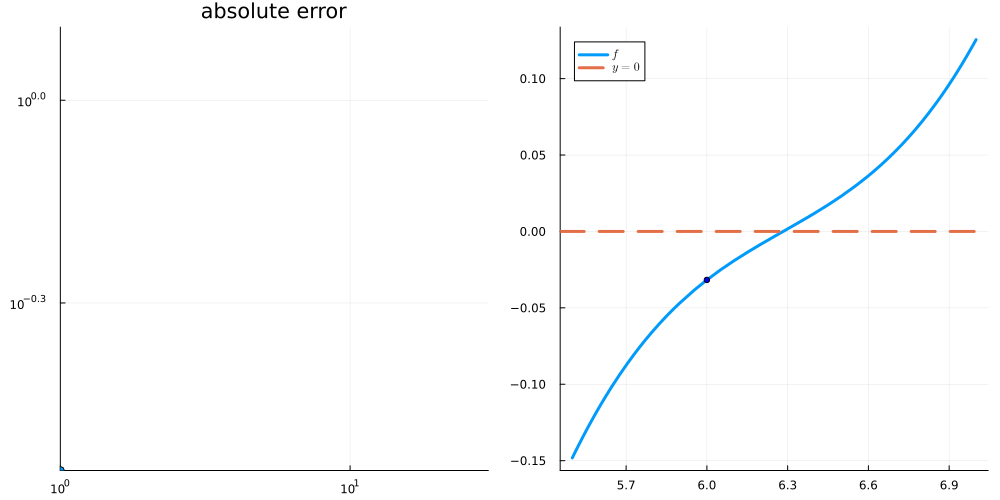

In [17]:
λ = 1;
x = relaxation( f, λ, 6.; N=30);

anim = @animate for n ∈ 1:length(x)
    err = abs.( x[1:n] .- ξ )
    plt1 = plot( err , 
        xlims=(1, length(x)), 
        ylims=(minimum(err), maximum(err)),
        yaxis=:log, xaxis=:log, m=:o, lw=3, 
        title="absolute error", legend=false )
    plt2 = plot( f, 5.5, 7, label=L"f", lw=3 )
    scatter!( [x[1:n]], [f.(x[1:n])], 
        primary=false, marker=3, color="blue")
    hline!( [0] , linestyle=:dash, lw = 3, label=L"y=0")

    plot( plt1, plt2, size=(1000,500) )
end
gif(anim, "Pictures/Relaxed.gif", fps = 1)

* Play around with $\lambda$, how does this affect the plot on the right?

<div class='alert alert-block alert-info'><b>Convergence Theorem (Relaxation)</b>  

Suppose that $f: [a,b]\to\mathbb R$ is continuously differentiable with $f(\xi) = 0$, $f'(\xi) \not= 0$. Then, there exists $\delta, \lambda> 0$ such that $x_{n+1} = x_n - \lambda f(x_n)$ converges at least linearly to $\xi$ for all $x_1 \in I_\delta := [\xi-\delta,\xi+\delta]$. The asymptotic error constant (for $\alpha =1$) is given by $\left| 1 - \lambda f'(\xi) \right|$.

 </div>

 <div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example (Kepler's equation).</strong> 


We have,

\begin{align*}
    &f(\psi) = \psi - \epsilon \sin \psi - 2\pi \qquad &f(2\pi) = 0 \nonumber\\
    &f'(\psi) = 1 - \epsilon \cos \psi \qquad &f'(2\pi) = 1 - \epsilon. \nonumber\\
\end{align*}

Therefore, for $\epsilon \not= 1$, we have $f(2\pi) = 0 \not= f'(2\pi)$ and so we can apply the above theorem. Relaxation converges linearly with asymptotic error constant $\mu := \left| 1 - \lambda f'(2\pi) \right| = \left| 1 - \lambda (1-\epsilon) \right|$. 

In the above example, we chose $\epsilon = 0.9$ and so the asymptotic error constant is $\left| 1 - 0.1\lambda \right|$. This is in good agreement with what we see numerically.

</div>

In [18]:
orderOfConvergence( x, 2π; α=1 )

┌───────────┬────────────────┬───────────┬─────────┬────────────┐
│ iteration │ absolute error │ log error │   alpha │ mu (α = 1) │
├───────────┼────────────────┼───────────┼─────────┼────────────┤
│       1.0 │       0.283185 │ -0.547929 │     NaN │        NaN │
│       2.0 │       0.251474 │ -0.599507 │ 1.09413 │   0.888019 │
│       3.0 │       0.223949 │ -0.649852 │ 1.08398 │   0.890544 │
│       4.0 │       0.199873 │ -0.699245 │ 1.07601 │   0.892496 │
│       5.0 │       0.178691 │ -0.747898 │ 1.06958 │    0.89402 │
│       6.0 │       0.159967 │ -0.795969 │ 1.06427 │   0.895218 │
│       7.0 │       0.143357 │ -0.843581 │ 1.05982 │   0.896166 │
│       8.0 │        0.12858 │ -0.890827 │ 1.05601 │    0.89692 │
│       9.0 │       0.115403 │ -0.937782 │ 1.05271 │   0.897522 │
│      10.0 │       0.103633 │ -0.984504 │ 1.04982 │   0.898004 │
│      11.0 │      0.0931025 │  -1.03104 │ 1.04727 │    0.89839 │
│      12.0 │      0.0836712 │  -1.07742 │ 1.04499 │     0.8987 │
│      13.

In [19]:
println( "f'(ξ) = ", f_prime(ξ))
println( "Theoretical asymptotic error constant μ = 1 - λf'(ξ) = ", 1 - λ*f_prime(ξ) )

f'(ξ) = 0.09999999999999998
Theoretical asymptotic error constant μ = 1 - λf'(ξ) = 0.9


 <div class='alert alert-block alert-success'><b>Proof.</b> 
 
Relaxation is a simple iteration with $g(x) = x - \lambda f(x)$. We wish to apply the contraction mapping theorem and thus it is sufficient to check $|g'(\xi)| \leq L < 1$.

 Suppose that $f'(\xi) > 0$ (the proof is very similar in the other case). Since $f'$ is continuous, there exists $\delta> 0$ such that 

 \begin{align*}
    m := \frac12 f'(\xi) \leq f'(x) \leq M := \max_{y\in [a,b]} f'(y).
 \end{align*}

As a result, we have $1 - \lambda M \leq 1 - \lambda f'(x) \leq 1 - \lambda m$. Choosing $L = 1 - \lambda m = \lambda M - 1$ gives $\lambda = \frac{2}{M+m}$ and thus 

\begin{align*}
    L = 1 - \frac{2m}{m + M} = \frac{M-m}{M+m} < 1.
\end{align*}
  </div> 

## Newton

* $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_{n})}$

┌ Info: Saved animation to c:\Users\math5\Math 5485\Lectures 1-12\Pictures\Newton.gif
└ @ Plots C:\Users\math5\.julia\packages\Plots\xKhUG\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\math5\\Math 5485\\Lectures 1-12\\Pictures\\Newton.gif")
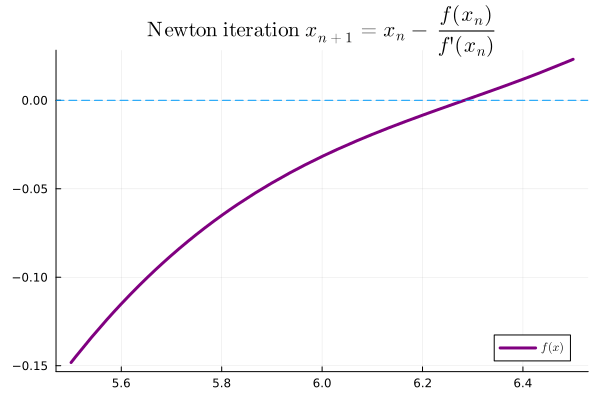

In [20]:
y = Newton( f, f_prime, 5.5; tol=1e-7);

plot( f , 5.5, 6.5, # ,1.5, #-.25, 2, 
    label=L"f(x)", lw=3, title=L"\textrm{Newton~iteration~} x_{n+1} = x_n - \frac{f(x_{n})}{f'(x_n)}",
    color="purple", linestyle=:solid)
hline!([0], linestyle=:dash, primary=false)

anim = @animate for n ∈ 1:2(length(y)-1)
    if (n==1)
        
    elseif (n%2 == 0)
        k = Int(n/2)
        plot!( [y[k], y[k]], [0, f(y[k])], 
            primary=false, lw=2, color="blue")
    else
        k = Int((n+1)/2)
        plot!( [y[k-1], y[k]], [f(y[k-1]), 0], 
            primary=false, lw=2, color="blue")
    end
end
gif(anim, "Pictures/Newton.gif", fps = 1)

<div class='alert alert-block alert-info'><b>Theorem.</b> 

Suppose $f: [a,b] \to \mathbb R$ is twice continuously differentiable with $f(\xi) = 0$ and $f'(\xi) \not= 0$ for some $\xi \in [a,b]$. Further suppose that 

\begin{align}
    \left|\frac{f''(x)}{f'(y)}\right| \leq A
\end{align}

for all $x,y \in [a,b]$. Then, the Newton iteration $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$ converges at least quadratically to $\xi$ for all $x_1 \in [a,b]$ such that $|x_1 - \xi| \leq A^{-1}$. The asymptotic error constant $\mu$ is $\frac12 \left|\frac{f''(\xi)}{f'(\xi)}\right|$.

</div> 

<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example.</strong> 


Notice that you have already seen an example of Newton's method! 

\begin{align}
    x_{n+1} = \frac12 \left( x_n + \frac{a}{x_n} \right)
\end{align}

which is the Newton iteration with $f(x) = x^2 - a$. Notice that $\xi = \sqrt{a}$ and $f'(\xi) = 2\sqrt{a}$, $f''(\xi) = 2$. You showed that the order of convergence is quadratic in this case. Compare with the theorem

</div>

In [21]:
g(x) = x^2 - 2
dg(x) = 2*x 
orderOfConvergence( Newton(g,dg,1.), sqrt(2); α=2 )

println( "theoretical value of μ (for α=2) = ",  (1/2) * ( 2/ dg(sqrt(2)) ) )

┌───────────┬────────────────┬───────────┬─────────┬────────────┐
│ iteration │ absolute error │ log error │   alpha │ mu (α = 2) │
├───────────┼────────────────┼───────────┼─────────┼────────────┤
│       1.0 │       0.414214 │ -0.382776 │     NaN │        NaN │
│       2.0 │      0.0857864 │  -1.06658 │ 2.78644 │        0.5 │
│       3.0 │      0.0024531 │  -2.61028 │ 2.44734 │   0.333333 │
│       4.0 │      2.1239e-6 │  -5.67287 │ 2.17328 │   0.352941 │
│       5.0 │    1.59472e-12 │  -11.7973 │  2.0796 │   0.353522 │
└───────────┴────────────────┴───────────┴─────────┴────────────┘
theoretical value of μ (for α=2) = 0.35355339059327373


<div class='alert alert-block alert-success'><b>Proof.</b> 

First, notice that $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_{n})}$ and so 

\begin{align}
    -f(x_n) &= f'(x_{n}) (x_{n+1} - x_{n}) \nonumber\\
        &= f'(x_{n}) (\xi - x_n) + f'(x_{n}) (x_{n+1} - \xi). 
\end{align}

At the same time, there exists $\eta_n$ between $x_n$ and $\xi$ such that 

\begin{align}
    0 = f(\xi) 
    &= f(x_n) + f'(x_n) ( \xi - x_{n} ) + \frac{1}{2} f''(\eta_n) (x_n - \xi)^2 \nonumber\\
    &= f(x_n) + \big[ -f(x_n) - f'(x_{n}) (x_{n+1} - \xi) \big] + \frac{1}{2} f''(\eta_n) (x_n - \xi)^2.
\end{align}

Therefore, assuming $x_n \in [a,b]$, we obtain 

\begin{align}
    \left| x_{n+1} - \xi \right| &= \frac{1}{2} \left| \frac{f''(\eta_n)}{f'(x_n)} \right| (x_n - \xi)^2 \nonumber\\
        %
        &\leq \frac12 A |x_n - \xi|^2.
\end{align}

If $|x_1 - \xi| \leq A^{-1}$ then, we have $|x_2 - \xi| \leq A |x_1 - \xi|^2 \leq A A^{-1} |x_1 - \xi| \leq A^{-1}$. Proceeding iteratively, we obtain $|x_{n} - \xi| \leq A^{-1}$. As a result, we have $\left| x_{n+1} - \xi \right| \leq \frac12 |x_n - \xi|$ and so $(x_n) \to \xi$. Finally, we have 

\begin{align}
    \frac{\left| x_{n+1} - \xi \right|}{|x_n - \xi|^2} = \frac{1}{2} \left| \frac{f''(\eta_n)}{f'(x_n)} \right| \to \frac12 \left| \frac{f''(\xi)}{f'(\xi)} \right|
\end{align}

as $n\to\infty$.
</div> 

 <div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example (Kepler's equation).</strong> 

Recall that

\begin{align*}
    &f(\psi) = \psi - \epsilon \sin \psi - 2\pi \qquad &f(2\pi) = 0 \nonumber\\
    &f'(\psi) = 1 - \epsilon \cos \psi \qquad &f'(2\pi) = 1 - \epsilon \nonumber\\
    &f''(\psi) = \epsilon \sin \psi \qquad &f''(2\pi) = 0 \nonumber\\
    &f'''(\psi) = \epsilon \cos \psi \qquad &f'''(2\pi) = \epsilon.
\end{align*}

Therefore, for $\epsilon \not= 1$, we can apply the above theorem. Newton therefore converges at least quadratically with asymptotic error constant $\mu = \frac12 \left| \frac{f''(2\pi )}{f'(2\pi)} \right| = 0$. As a result, we would expect Newton iteration to converge super-quadratically in this case:

</div>

In [22]:
orderOfConvergence( y, 2π ; α = 2)
# plot( abs.( y .- ξ ) , yaxis=:log, xaxis=:log, m=:o, lw=3, title="absolute error", legend=false )

┌───────────┬────────────────┬───────────┬─────────┬────────────┐
│ iteration │ absolute error │ log error │   alpha │ mu (α = 2) │
├───────────┼────────────────┼───────────┼─────────┼────────────┤
│       1.0 │       0.783185 │ -0.106135 │     NaN │        NaN │
│       2.0 │       0.374019 │ -0.427107 │ 4.02417 │   0.609767 │
│       3.0 │      0.0954133 │  -1.02039 │ 2.38908 │    0.68206 │
│       4.0 │     0.00250109 │  -2.60187 │ 2.54988 │   0.274733 │
│       5.0 │     4.69349e-8 │   -7.3285 │ 2.81663 │ 0.00750305 │
└───────────┴────────────────┴───────────┴─────────┴────────────┘


<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'> 

In fact, in this case the convergence is cubic with asymptotic error constant $\mu = \frac13 \left| \frac{f'''(\xi)}{f'(\xi)} \right| = \frac13 \frac{\epsilon}{1-\epsilon}$ (**Exercise**: why?). 

</div> 

In [23]:
println( "theoretical value of μ (for α=3) = ",  (1/3) * ( ϵ/ (1-ϵ) ) ) 

theoretical value of μ (for α=3) = 3.0000000000000004


<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'>

In your assignment, you will experiment with the case $\epsilon = 1$ and so $f(2\pi) = f'(2\pi) = f''(2\pi) = 0$.

 </div> 

## Secant Method

* Consider $x_{n+1} = g(x_n, x_{n-1})$ 
* Consider Newton but with an approximate derivative: 

\begin{align}
    f'(x_n) &\approx \frac{f(x_{n}) - f(x_{n-1})}{x_{n} - x_{n-1}}
    \nonumber\\ &= f[x_n, x_{n-1}] 
\end{align}

* That is, $x_{n+1} = x_n - \frac{f(x_n)}{f[x_n, x_{n-1}]}$

┌ Info: Saved animation to c:\Users\math5\Math 5485\Lectures 1-12\Pictures\Secant.gif
└ @ Plots C:\Users\math5\.julia\packages\Plots\xKhUG\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\math5\\Math 5485\\Lectures 1-12\\Pictures\\Secant.gif")
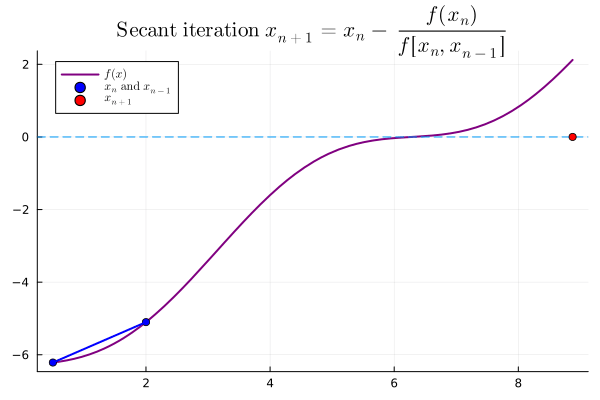

In [24]:
function secant( f, x1, x2; N=100, tol=1e-8)
    x = [x1, x2];
    for n in 3:N 
       push!(x, x[n-1] - ((x[n-1] - x[n-2])/(f(x[n-1]) - f(x[n-2]))) * f(x[n-1]) )
       if (abs(f(x[end])) < tol)
            break
        end
    end
    return x
end

z = secant( f, 0.5, 2.0 ,N=20)

anim = @animate for n ∈ 3:length(z)
    plot( f , minimum(z), maximum(z), # ,1.5, #-.25, 2, 
    label=L"f(x)", title=L"\textrm{Secant~iteration~} x_{n+1} = x_n - \frac{f(x_n)}{f[x_n,x_{n-1}]}",
    color="purple", linestyle=:solid, lw=2)
hline!([0], linestyle=:dash, primary=false)

    scatter!( [z[n-2], z[n-1]], [f(z[n-2]), f(z[n-1])], color="blue", label=L"x_{n} \textrm{~and~} x_{n-1}" )
    plot!( [z[n-2], z[n-1]], [f(z[n-2]), f(z[n-1])], 
            primary=false, lw=2, color="blue")
    scatter!( [z[n]], [0], color="red", label=L"x_{n+1}")
end
gif(anim, "Pictures/Secant.gif", fps = 1)

<div class='alert alert-block alert-info'><b>Theorem.</b> 

Suppose $f: [a,b] \to \mathbb R$ is continuously differentiable with $f(\xi) = 0$ and $f'(\xi) \not= 0$ for some $\xi \in [a,b]$. Then, the Secant iteration $x_{n+1} = x_n - \frac{f(x_n)}{f[x_n,x_{n-1}]}$ converges at least linearly to $\xi$ for all $x_1,x_2$ sufficiently close to $\xi$. 
</div> 

<div class='alert alert-block alert-danger'><b>Remark.</b> 

In fact, order of convergence $\alpha = \frac{1 + \sqrt{5}}{2}$ in this case, with $\mu =  \left| \frac{f''(\xi)}{2 f'(\xi)} \right|^{\alpha/(1 + \alpha)}$. 

</div> 

<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example.</strong> 

Let's try and approximate $\sqrt{2}$ again:

</div> 

In [25]:
# g(x) = x^2 - 2 is already defined 

a = (1/2)*(1 + sqrt(5));
mu = ( 2/(2*2*sqrt(2)) )^(a/(1+a));

orderOfConvergence( secant( g, 1. ,2. ), sqrt(2); α=a )
println("theoretical values of (α, μ) = (", a, ", " , mu, ")" )


┌───────────┬────────────────┬───────────┬─────────┬────────────────────────────
│ iteration │ absolute error │ log error │   alpha │ mu (α = 1.618033988749895 ⋯
├───────────┼────────────────┼───────────┼─────────┼────────────────────────────
│       1.0 │       0.414214 │ -0.382776 │     NaN │                        Na ⋯
│       2.0 │       0.585786 │ -0.232261 │ 0.60678 │                    2.4382 ⋯
│       3.0 │      0.0808802 │  -1.09216 │ 4.70229 │                   0.19215 ⋯
│       4.0 │      0.0142136 │   -1.8473 │ 1.69142 │                   0.83147 ⋯
│       5.0 │    0.000420584 │  -3.37615 │ 1.82761 │                   0.41005 ⋯
│       6.0 │      2.1239e-6 │  -5.67287 │ 1.68028 │                   0.61638 ⋯
│       7.0 │    3.15775e-10 │  -9.50062 │ 1.67475 │                   0.47672 ⋯
└───────────┴────────────────┴───────────┴─────────┴────────────────────────────
                                                                1 column omitted
theoretical values of (α, μ)

<div class='alert alert-block alert-success'><b>Proof.</b> 

Again, we may apply Taylor's remainder theorem: there exists $\eta_n$ between $x_n$ and $x_{n-1}$ such that $f[x_n, x_{n-1}] = f'(\eta_n)$ and $\theta_n$ between $x_n$ and $\xi$ such that $f(x_n) = f'(\xi)(x_n - \xi)$. As a result, we have  

\begin{align}
    x_{n+1} - \xi &= x_n - \xi - \frac{f(x_n)}{ f[x_n, x_{n-1}] } \nonumber\\
    %
    &= \left( 1 - \frac{f'(\theta_n)}{ f'(\eta_n) } \right) (x_n - \xi) 
\end{align}

If $f'(\xi) > 0$, then there exists a closed interval $I = [\xi-\delta, \xi+\delta]$ such that 

\begin{align*}
    0 < \frac34 f'(\xi) < f'(x) < \frac54 f'(\xi)
\end{align*}

for all $x \in I$. If $x_n, x_{n-1} \in I$ then $\eta_n, \theta_n \in I$ and so we have $\frac23 < 1 - \frac{f'(\theta_n)}{ f'(\eta_n) } < \frac25$ and thus $x_{n+1} \in I$ with 

\begin{align}
    |x_{n+1} - \xi| \leq \frac23 |x_{n}-\xi| \leq \cdots \leq \left(\frac23\right)^n |x_1 - \xi|.
\end{align}

That is, the sequence converges at least linearly. Moreover, by (1), we have $|x_{n+1}-\xi|/|x_n - \xi| \to 0$ as $n\to\infty$.

</div> 

<div style='background-color: #ddff99; padding: 10px; border-left: 5px solid #009933;'><strong>Definition (Efficiency index)</strong> 

The efficiency index is $E := \alpha^{1/\theta}$ where $\theta$ is the number of function evaluations at each step of the iteration. This measures the order of the method *per function evaluation*

</div> 

<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example.</strong> 

Newton when $f'(\xi), f''(\xi) \not= 0$, we have $E = 2^{1/2} \approx 1.41...$ since the order of convergence is $2$ and we need to evaluate $f$ and $f'$ at $x_n$.

Secant when $f'(\xi) \not= 0$, we have $E = \left[\frac12\big( 1 + \sqrt{5} \big)\right]^{1/1} \approx 1.618...$ since the order of convergence is $\frac12\big( 1 + \sqrt{5} \big)$ and we only require one function evaluation per iteration.

 </div> 